In [1]:
import os
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches, colors
import seaborn as sns
import numpy as np
from numpy import ma
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.plot as ep
import earthpy.mask as em

In [2]:
sns.set_style('white')
sns.set(font_scale=1.5)

os.chdir(os.path.join(et.io.HOME,'earth-analytics','data'))

In [3]:
def open_clean_band(band_path, crop_layer=None):
    if crop_layer is not None:
        try:
            clip_bound = crop_layer.geometry
            cleaned_band = rxr.open_rasterio(band_path,
                                             masked=True).rio.clip(clip_bound,
                                                                   from_disk=True).squeeze()
        except Exception as err:
            print("Oops, I need a geodataframe object for this to work.")
            print(err)
    else:
        cleaned_band = rxr.open_rasterio(band_path,
                                         masked=True).squeeze()

    return cleaned_band

def process_bands(paths, crop_layer=None, stack=False):
    all_bands = []
    for i, aband in enumerate(paths):
        cleaned = open_clean_band(aband, crop_layer)
        cleaned["band"] = i+1
        all_bands.append(cleaned)

    if stack:
        print("I'm stacking your data now.")
        return xr.concat(all_bands, dim="band")
    else:
        print("Returning a list of xarray objects.")
        return all_bands

In [4]:
landsat_dirpath_pre = os.path.join("cold-springs-fire",
                                   "landsat_collect",
                                   "LC080340322016070701T1-SC20180214145604",
                                   "crop",
                                   "*band[2-5]*.tif")

landsat_paths_pre = sorted(glob(landsat_dirpath_pre))

landsat_pre = process_bands(landsat_paths_pre, stack=True)
landsat_pre

I'm stacking your data now.


<xarray.DataArray (band: 4, y: 177, x: 246)> Size: 697kB
array([[[ 443.,  456.,  446., ...,  213.,  251.,  293.],
        [ 408.,  420.,  436., ...,  226.,  272.,  332.],
        [ 356.,  375.,  373., ...,  261.,  329.,  383.],
        ...,
        [ 407.,  427.,  428., ...,  306.,  273.,  216.],
        [ 545.,  552.,  580., ...,  307.,  315.,  252.],
        [ 350.,  221.,  233., ...,  320.,  348.,  315.]],

       [[ 635.,  641.,  629., ...,  360.,  397.,  454.],
        [ 601.,  617.,  620., ...,  380.,  418.,  509.],
        [ 587.,  600.,  573., ...,  431.,  513.,  603.],
        ...,
        [ 679.,  742.,  729., ...,  493.,  482.,  459.],
        [ 816.,  827.,  824., ...,  461.,  502.,  485.],
        [ 526.,  388.,  364., ...,  463.,  501.,  512.]],

       [[ 625.,  671.,  651., ...,  265.,  307.,  340.],
        [ 568.,  620.,  627., ...,  309.,  354.,  431.],
        [ 513.,  510.,  515., ...,  362.,  464.,  565.],
        ...,
        [ 725.,  834.,  864., ...,  485.,  467.,  457.],
        [1031.,  864.,  844., ...,  438.,  457.,  429.],
        [ 525.,  432.,  411., ...,  465.,  472.,  451.]],

       [[2080., 1942., 1950., ..., 1748., 1802., 2135.],
        [2300., 2045., 1939., ..., 1716., 1783., 2131.],
        [2582., 2443., 2347., ..., 1836., 2002., 2241.],
        ...,
        [2076., 1993., 2145., ..., 1914., 2066., 2166.],
        [1910., 1899., 1962., ..., 1787., 2038., 2300.],
        [1633., 1611., 1738., ..., 1714., 1848., 2194.]]], dtype=float32)
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 2kB 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
  * y            (y) float64 1kB 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  8481
    STATISTICS_MEAN:     664.90340361031
    STATISTICS_MINIMUM:  -767
    STATISTICS_STDDEV:   1197.873301452
    scale_factor:        1.0
    add_offset:          0.0

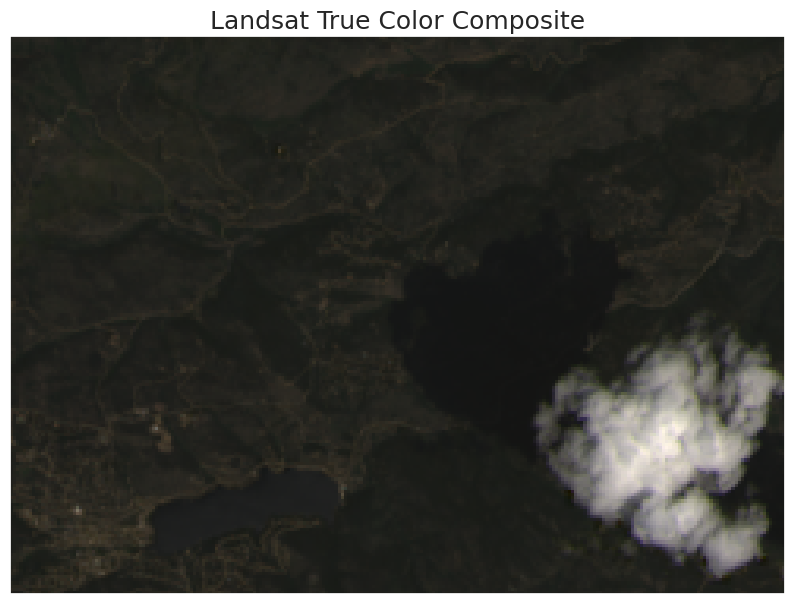

In [5]:
ep.plot_rgb(landsat_pre.values,
            rgb=[2, 1, 0],
            title="Landsat True Color Composite")
plt.show()

In [6]:
landsat_pre_cl_path = os.path.join("cold-springs-fire",
                                   "landsat_collect",
                                   "LC080340322016070701T1-SC20180214145604",
                                   "crop",
                                   "LC08_L1TP_034032_20160707_20170221_01_T1_pixel_qa_crop.tif")

landsat_qa = rxr.open_rasterio(landsat_pre_cl_path).squeeze()

high_cloud_confidence = em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"]
cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

all_masked_values = cloud_shadow + cloud + high_cloud_confidence

landsat_pre_cl_free = landsat_pre.where(~landsat_qa.isin(all_masked_values))

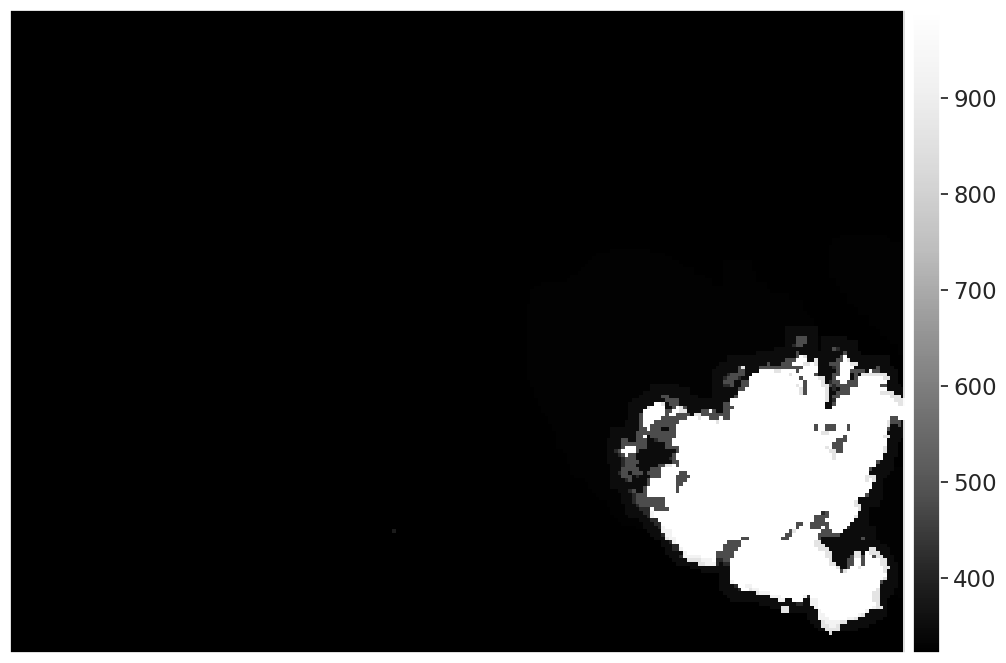

<Axes: >

In [7]:
ep.plot_bands(landsat_qa)

In [8]:
cl_mask = landsat_qa.isin(all_masked_values)
np.unique(cl_mask)

array([False,  True])

/tmp/ipykernel_3445/4256314328.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('tab20b', 2))


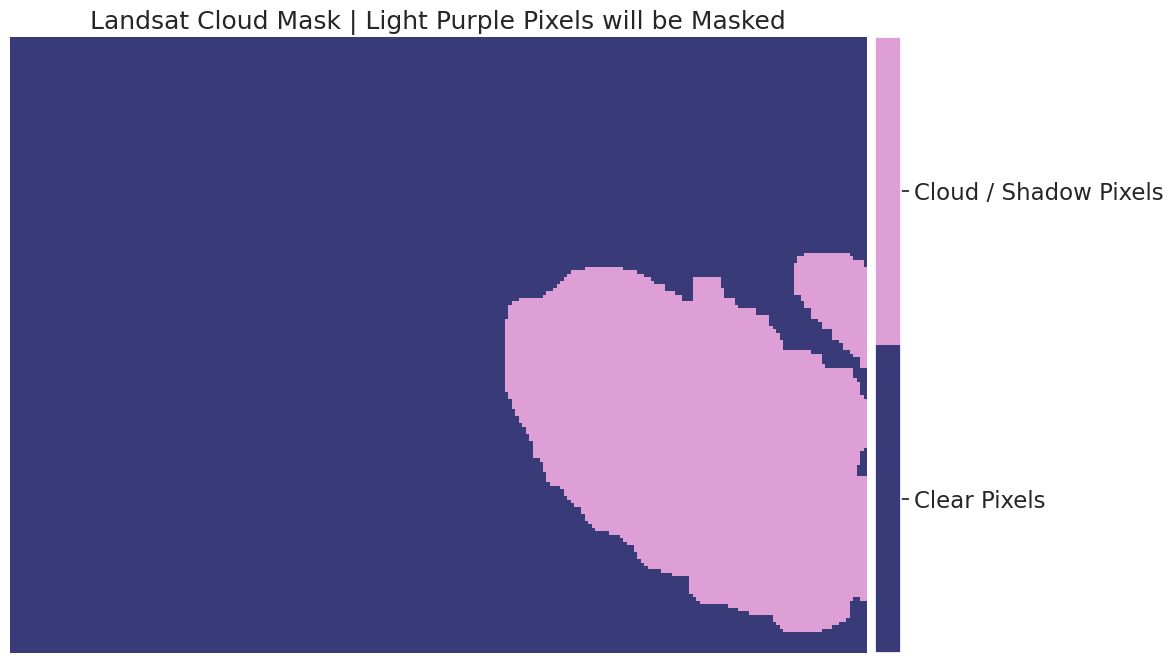

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.imshow(cl_mask,
               cmap=plt.cm.get_cmap('tab20b', 2))

cbar = ep.colorbar(im)
cbar.set_ticks((0.25, .75))
cbar.ax.set_yticklabels(["Clear Pixels", "Cloud / Shadow Pixels"])

ax.set_title("Landsat Cloud Mask | Light Purple Pixels will be Masked")

ax.set_axis_off()

plt.show()

In [10]:
landsat_pre_cl_free = landsat_pre.where(~cl_mask)

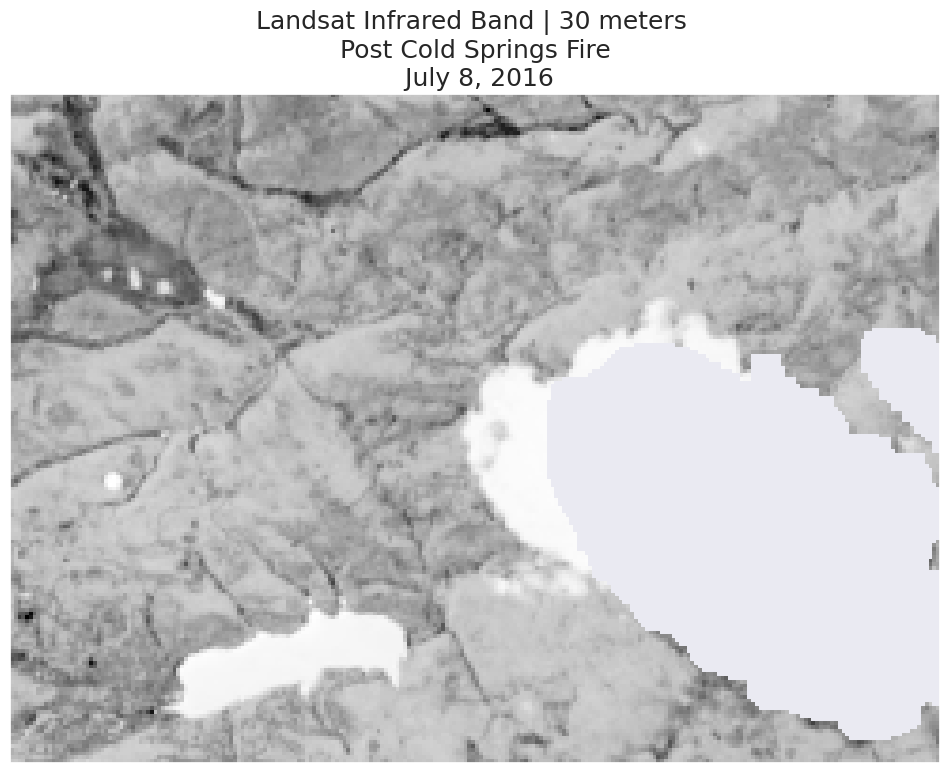

In [11]:
ep.plot_bands(landsat_pre_cl_free[3],
              cmap="Greys",
              title="Landsat Infrared Band | 30 meters \n Post Cold Springs Fire \n July 8, 2016",
              cbar=False)
plt.show()

/home/codespace/.python/current/lib/python3.10/site-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


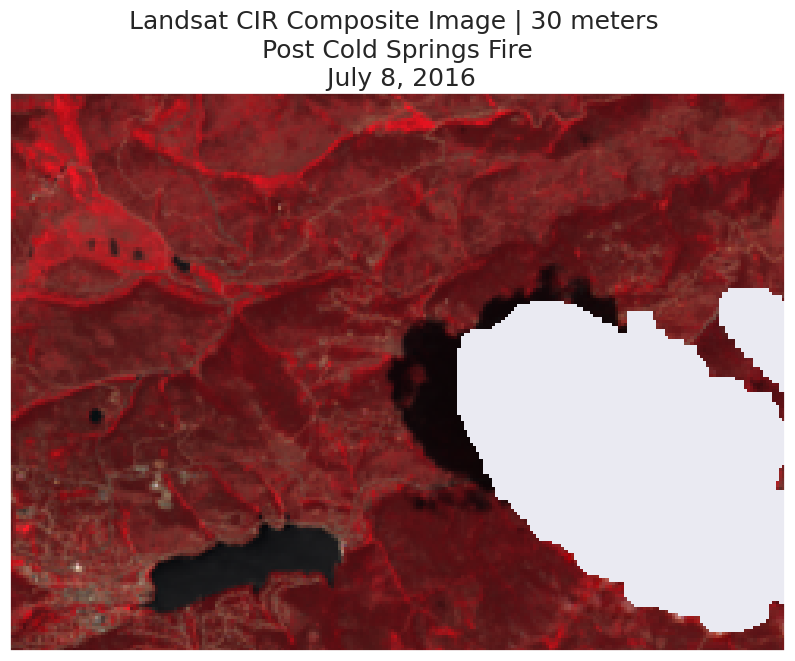

In [12]:
ep.plot_rgb(landsat_pre_cl_free,
            rgb=[3, 2, 1],
            title="Landsat CIR Composite Image | 30 meters \n Post Cold Springs Fire \n July 8, 2016")
plt.show()